In [110]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# this is the funstion to set seed value which will ensure consistent results
def set_seed(seed_value):
    np.random.seed(seed_value)

# this is the seed value which will ensure consistent results
seed_value = 9  
set_seed(seed_value) 

# Ensure inline plotting in Jupyter
%matplotlib inline


In [111]:
# Function to load all images from the current folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):  # Only process .jpg files
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((filename, img))
                print(f"Loaded image: {filename}")  # Debug: Print the image loaded
            else:
                print(f"Failed to load image: {filename}")  # Debug: Failed loading
    return images

folder = './Ass2'  # Path to your images folder
images = load_images_from_folder(folder)

if not images:
    print("No images found in the folder.")


Loaded image: T22.jpg
Loaded image: T32.jpg
Loaded image: T42.jpg
Loaded image: T52.jpg
Loaded image: T62.jpg


In [112]:
# Otsu’s Method Multilevel Thresholding
def otsu_multilevel_thresholding(image, levels):
    thresholds = []
    current_image = image.copy()

    for _ in range(levels - 1):
        thresh_value, _ = cv2.threshold(current_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(thresh_value)
        current_image = np.where(current_image >= thresh_value, 0, current_image)

    segmented_image = np.zeros_like(image)
    for i, thresh in enumerate(sorted(thresholds)):
        segmented_image[np.where(image >= thresh)] = (i + 1) * (255 // levels)

    return segmented_image, thresholds

# Kapur’s Method Thresholding (maximizes entropy)
def kapur_threshold(image, levels):
    # Compute the histogram and normalize it
    hist, bins = np.histogram(image.ravel(), bins=256, range=[0, 256])
    hist = hist.astype(np.float32) / hist.sum()

    def entropy(thresh):
        prob1 = hist[:thresh].sum()
        prob2 = hist[thresh:].sum()
        prob1 = prob1 if prob1 > 0 else 1
        prob2 = prob2 if prob2 > 0 else 1
        return -(np.log(prob1) * prob1 + np.log(prob2) * prob2)

    thresholds = []
    current_image = image.copy()
    
    for _ in range(levels - 1):
        # Calculate entropy for all possible threshold values in the remaining region
        entropies = [entropy(thresh) for thresh in range(1, 255)]
        best_thresh = np.argmax(entropies)
        thresholds.append(best_thresh)
        
        # Split the image at the current threshold and only look for thresholds in the remaining regions
        hist[:best_thresh] = 0  # Set the current region to zero to avoid reselecting it
        
    # Sort the thresholds for correct segmentation
    thresholds = sorted(thresholds)
    thresholds = [0] + thresholds + [255]  # Add 0 and 255 as the boundary thresholds

    # Segment the image based on the thresholds
    segmented_image = np.zeros_like(image)
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i + 1])
        segmented_image[mask] = (i + 1) * (255 // levels)

    # Normalize the segmented image for better visualization
    normalized_segmented_image = cv2.normalize(segmented_image, None, 0, 255, cv2.NORM_MINMAX)

    return normalized_segmented_image, thresholds

In [113]:
# Simulated Annealing for Thresholding Optimization
def simulated_annealing(image, objective_function, levels, initial_temperature=1000, cooling_rate=0.95):
    def perturb(thresholds):
        idx = np.random.randint(0, len(thresholds))
        thresholds[idx] += np.random.randint(-10, 10)
        thresholds = np.clip(thresholds, 0, 255)
        return thresholds

    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    current_cost = objective_function(image, current_thresholds)
    temperature = initial_temperature

    while temperature > 1:
        new_thresholds = perturb(current_thresholds.copy())
        new_cost = objective_function(image, new_thresholds)

        if new_cost < current_cost or np.random.random() < np.exp((current_cost - new_cost) / temperature):
            current_thresholds = new_thresholds
            current_cost = new_cost

        temperature *= cooling_rate

    return current_thresholds

# Variable Neighbourhood Search for Thresholding Optimization
def vns(image, objective_function, levels):
    current_thresholds = np.sort(np.random.randint(0, 255, size=(levels - 1)))
    best_cost = objective_function(image, current_thresholds)

    def local_search(thresholds):
        for i in range(len(thresholds)):
            for change in [-5, 5]:
                new_thresholds = thresholds.copy()
                new_thresholds[i] += change
                new_thresholds = np.clip(new_thresholds, 0, 255)
                new_cost = objective_function(image, new_thresholds)
                if new_cost < best_cost:
                    return new_thresholds, new_cost
        return thresholds, best_cost

    while True:
        new_thresholds, new_cost = local_search(current_thresholds)
        if new_cost < best_cost:
            current_thresholds = new_thresholds
            best_cost = new_cost
        else:
            break

    return current_thresholds

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def display_images(images, titles, cols=2, figsize=(5, 3)):  
    rows = (len(images) + cols - 1) // cols  # Calculate the number of rows dynamically
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    if rows == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Debug: Print unique values for each image
            unique_values = np.unique(images[i])
            # print(f"Image: {titles[i]}, Unique values: {unique_values}")

            # Normalize the segmented images for better visualization
            norm_img = cv2.normalize(images[i], None, 0, 255, cv2.NORM_MINMAX)
            
            # Display original image in grayscale
            if 'Original' in titles[i]:
                ax.imshow(norm_img, cmap='gray')  # Ensure original is grayscale
            # Apply 'jet' colormap if there are 3 or more unique values (sections)
            elif len(unique_values) >= 3:
                ax.imshow(norm_img, cmap='jet', vmin=0, vmax=255)  # Use 'jet' colormap with normalization
            else:
                ax.imshow(norm_img, cmap='gray')  # Use grayscale if fewer than 3 sections
            
            ax.set_title(titles[i], fontsize=8)  # Reduced title font size for smaller images
        else:
            ax.axis('off')  # Hide unused subplots
        ax.axis('off')  # Turn off the axis ticks

    plt.tight_layout()
    plt.show()

def display_histograms(images, titles, thresholds_list=None, cols=2, figsize=(5, 3)):
    rows = (len(images) + cols - 1) // cols  # Calculate the number of rows dynamically
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Calculate the histogram data without plotting to get max value
            hist_data, bins = np.histogram(images[i].ravel(), bins=256, range=[0, 256])
            
            # Plot the histogram
            ax.hist(images[i].ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
            
            # Add vertical lines for the thresholds (if provided)
            if thresholds_list and thresholds_list[i] is not None:
                for thresh in thresholds_list[i]:
                    ax.axvline(x=thresh, color='red', linestyle='--', linewidth=1)  # Dashed red line for each threshold
            
            # Adjust y-limit to 10% above the max frequency
            ax.set_ylim(0, hist_data.max() * 1.1)
            
            ax.set_title(f'Histogram of {titles[i]}', fontsize=8)
            ax.set_xlabel('Pixel Intensity', fontsize=6)
            ax.set_ylabel('Frequency', fontsize=6)
            ax.grid(True)
        else:
            ax.axis('off')  # Hide unused subplots
        ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust tick sizes

    plt.tight_layout()
    plt.show()



# Function to display histograms
# def display_histograms(images, titles, thresholds_list=None, cols=2, figsize=(5, 3)):
#     rows = (len(images) + cols - 1) // cols  # Calculate the number of rows dynamically
#     fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
#     for i, ax in enumerate(axes.flat):
#         if i < len(images):
#             # Plot the histogram
#             ax.hist(images[i].ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
            
#             # Add vertical lines for the thresholds (if provided)
#             if thresholds_list and thresholds_list[i] is not None:
#                 for thresh in thresholds_list[i]:
#                     ax.axvline(x=thresh, color='red', linestyle='--', linewidth=1)  # Dashed red line for each threshold
            
#             ax.set_title(f'Histogram of {titles[i]}', fontsize=8)
#             ax.set_xlabel('Pixel Intensity', fontsize=6)
#             ax.set_ylabel('Frequency', fontsize=6)
#             ax.grid(True)
#         else:
#             ax.axis('off')  # Hide unused subplots
#         ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust tick sizes

#     plt.tight_layout()
#     plt.show()


# Logging function to print and store results
def log_results(df, image_name, level, method, optimization, thresholds, obj_value, ssim_value, psnr_value, unique_values):
    new_row = pd.DataFrame({
        'Image': [image_name], 
        'Level': [level], 
        'Method': [method], 
        'Optimization': [optimization], 
        'Thresholds': [thresholds], 
        'Unique Values': [unique_values],
        'Objective Value': [obj_value], 
        'SSIM': [ssim_value], 
        'PSNR': [psnr_value]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    return df


# Objective function (Otsu)
def otsu_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_var = 0
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        region = image[mask]
        if len(region) > 0:
            total_var += np.var(region) * len(region)
    return total_var

# Objective function (Kapur)
def kapur_objective(image, thresholds):
    thresholds = [0] + sorted(thresholds) + [255]
    total_entropy = 0
    for i in range(len(thresholds) - 1):
        mask = (image >= thresholds[i]) & (image < thresholds[i+1])
        hist, _ = np.histogram(image[mask], bins=256, range=[0, 256])
        hist = hist.astype(np.float32) / hist.sum()
        entropy = -np.sum(hist * np.log(hist + 1e-10))
        total_entropy += entropy
    return -total_entropy


# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Image', 'Level', 'Method', 'Optimization', 'Thresholds', 'Objective Value', 'SSIM', 'PSNR'])


Processing image: T22.jpg
Processing k=2
Unique values for T22_SA_Otsu_k2: [  0 127]
Unique values for T22_SA_Kapur_k2: [  0 255]
Unique values for T22_VNS_Otsu_k2: [  0 127]
Unique values for T22_VNS_Kapur_k2: [  0 255]
Processing k=3
Unique values for T22_SA_Otsu_k3: [  0  85 170]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T22_SA_Kapur_k3: [  0 128 255]
Unique values for T22_VNS_Otsu_k3: [  0  85 170]
Unique values for T22_VNS_Kapur_k3: [  0 128 255]
Processing k=4
Unique values for T22_SA_Otsu_k4: [  0  63 126 189]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T22_SA_Kapur_k4: [  0  85 170 255]
Unique values for T22_VNS_Otsu_k4: [  0  63 126 189]
Unique values for T22_VNS_Kapur_k4: [  0  85 170 255]
Processing k=5
Unique values for T22_SA_Otsu_k5: [  0  51 102 153 204]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T22_SA_Kapur_k5: [  0  64 128 191 255]
Unique values for T22_VNS_Otsu_k5: [  0  51 102 153 204]
Unique values for T22_VNS_Kapur_k5: [  0  64 128 191 255]


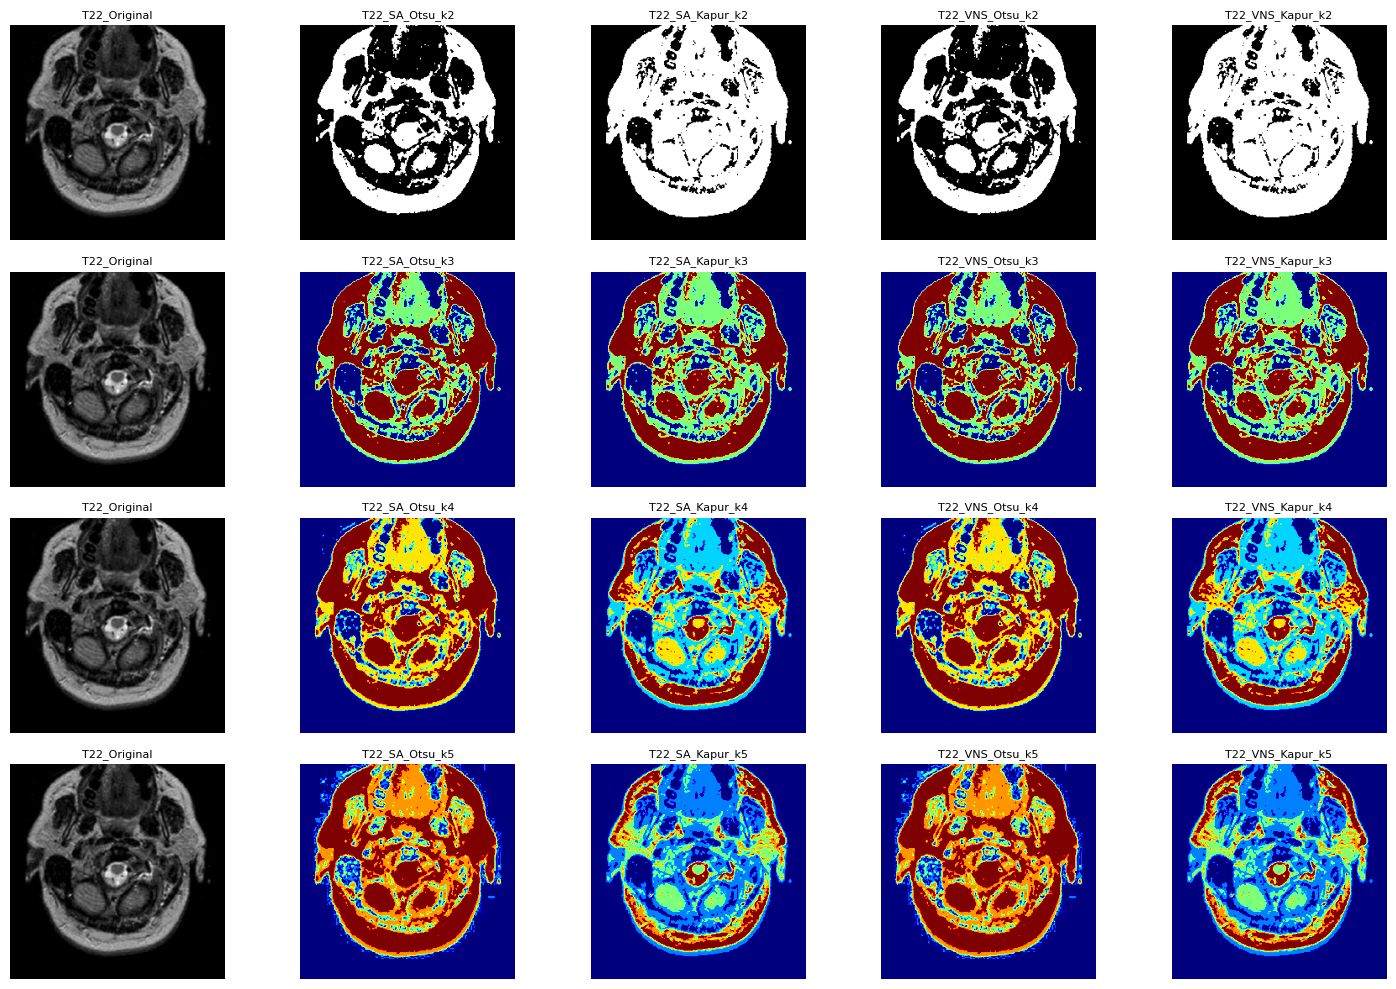

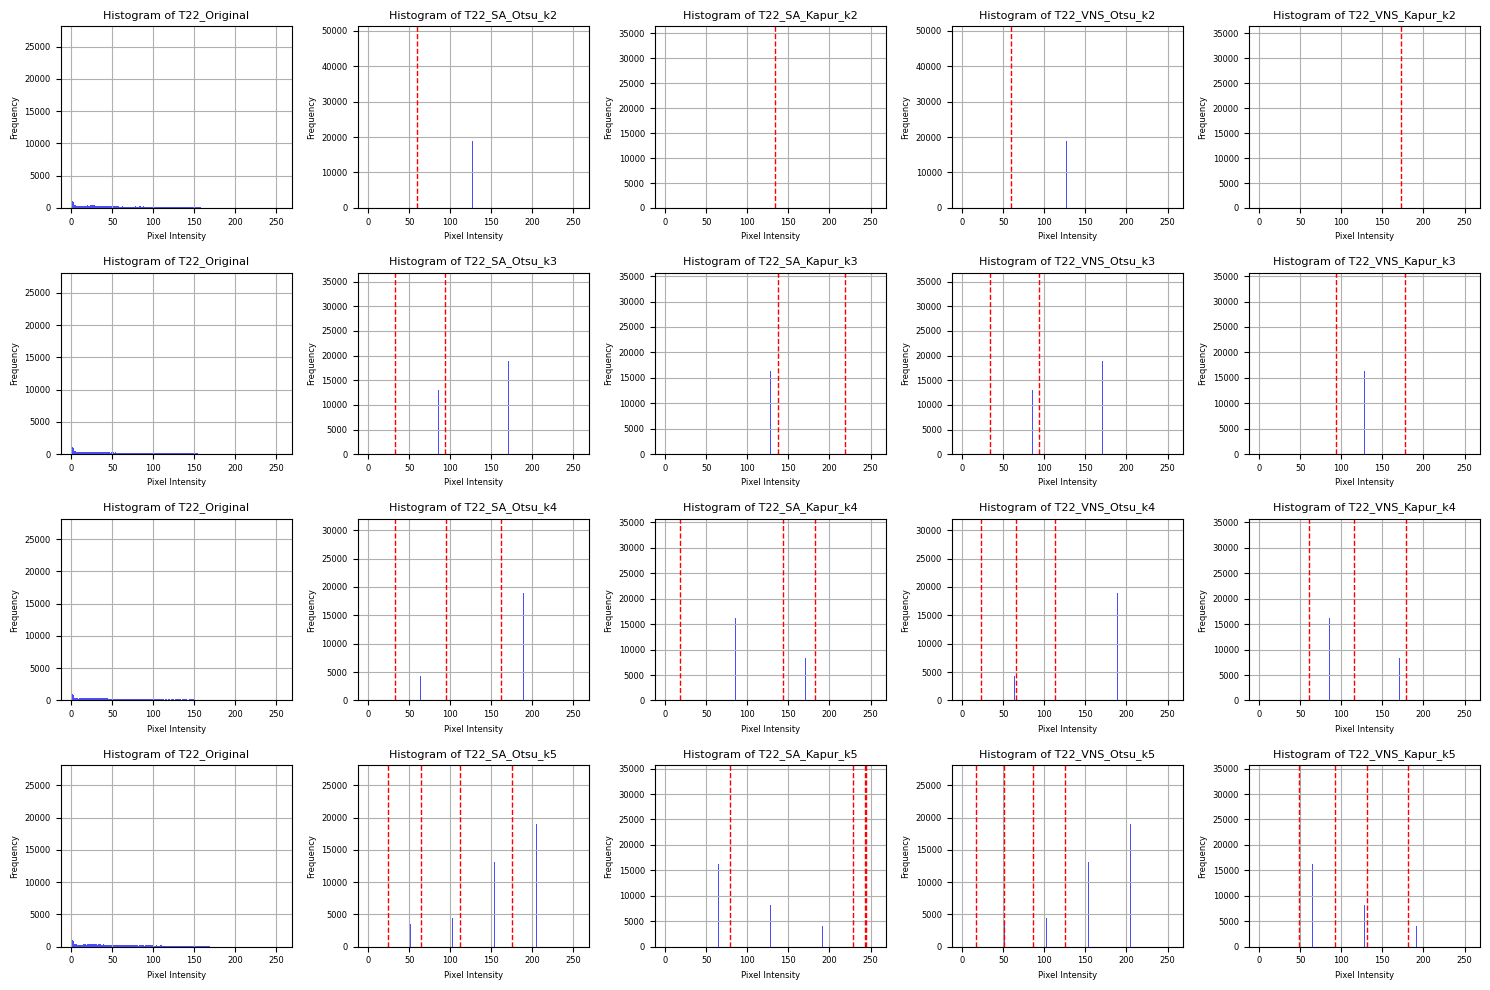

Processing image: T32.jpg
Processing k=2
Unique values for T32_SA_Otsu_k2: [  0 127]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T32_SA_Kapur_k2: [  0 128 255]
Unique values for T32_VNS_Otsu_k2: [  0 127]
Unique values for T32_VNS_Kapur_k2: [  0 128 255]
Processing k=3
Unique values for T32_SA_Otsu_k3: [  0  85 170]
Unique values for T32_SA_Kapur_k3: [  0  85 170 255]
Unique values for T32_VNS_Otsu_k3: [  0  85 170]
Unique values for T32_VNS_Kapur_k3: [  0  85 170 255]
Processing k=4
Unique values for T32_SA_Otsu_k4: [  0  63 126 189]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T32_SA_Kapur_k4: [  0  64 127 191 255]
Unique values for T32_VNS_Otsu_k4: [  0  63 126 189]
Unique values for T32_VNS_Kapur_k4: [  0  64 127 191 255]
Processing k=5
Unique values for T32_SA_Otsu_k5: [  0  51 102 153 204]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T32_SA_Kapur_k5: [  0  51 102 153 204 255]
Unique values for T32_VNS_Otsu_k5: [  0  51 102 153 204]
Unique values for T32_VNS_Kapur_k5: [  0  51 102 153 204 255]


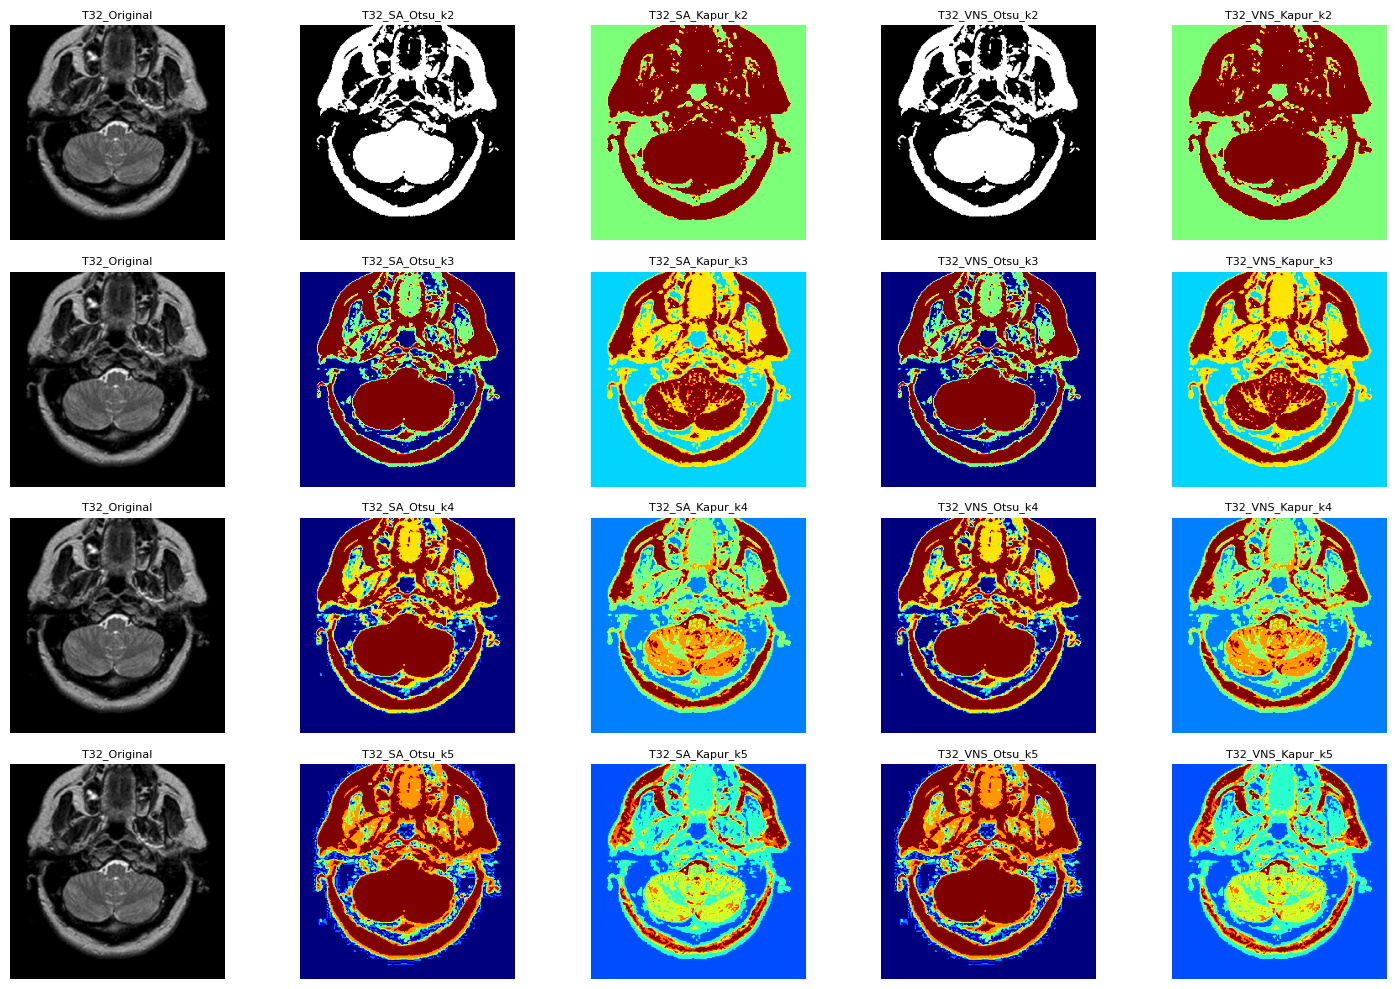

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x0000021C19DC2700>
Traceback (most recent call last):
  File "c:\Users\seans\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


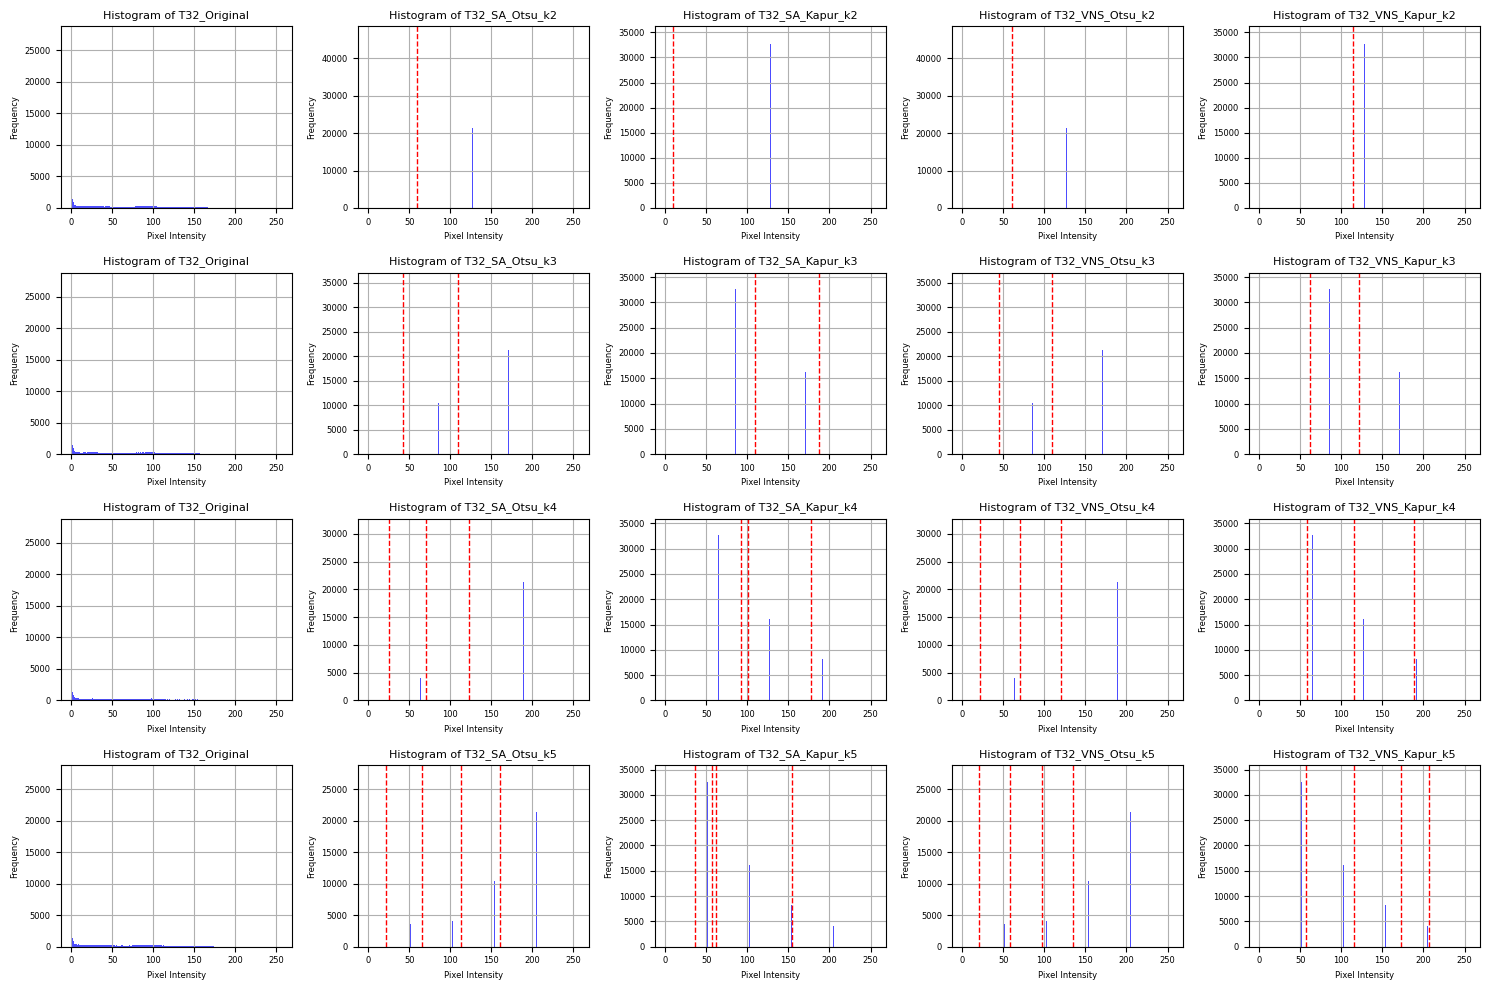

Processing image: T42.jpg
Processing k=2
Unique values for T42_SA_Otsu_k2: [  0 127]
Unique values for T42_SA_Kapur_k2: [  0 128 255]
Unique values for T42_VNS_Otsu_k2: [  0 127]
Unique values for T42_VNS_Kapur_k2: [  0 128 255]
Processing k=3
Unique values for T42_SA_Otsu_k3: [  0  85 170]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T42_SA_Kapur_k3: [  0  85 170 255]
Unique values for T42_VNS_Otsu_k3: [  0  85 170]
Unique values for T42_VNS_Kapur_k3: [  0  85 170 255]
Processing k=4
Unique values for T42_SA_Otsu_k4: [  0  63 126 189]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T42_SA_Kapur_k4: [  0  64 127 191 255]
Unique values for T42_VNS_Otsu_k4: [  0  63 126 189]
Unique values for T42_VNS_Kapur_k4: [  0  64 127 191 255]
Processing k=5
Unique values for T42_SA_Otsu_k5: [  0  51 102 153 204]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T42_SA_Kapur_k5: [  0  51 102 153 204 255]
Unique values for T42_VNS_Otsu_k5: [  0  51 102 153 204]


C:\Users\seans\AppData\Local\Temp\ipykernel_37028\1589901061.py:133: RuntimeWarning: invalid value encountered in divide
  hist = hist.astype(np.float32) / hist.sum()


Unique values for T42_VNS_Kapur_k5: [  0  51 102 153 204 255]


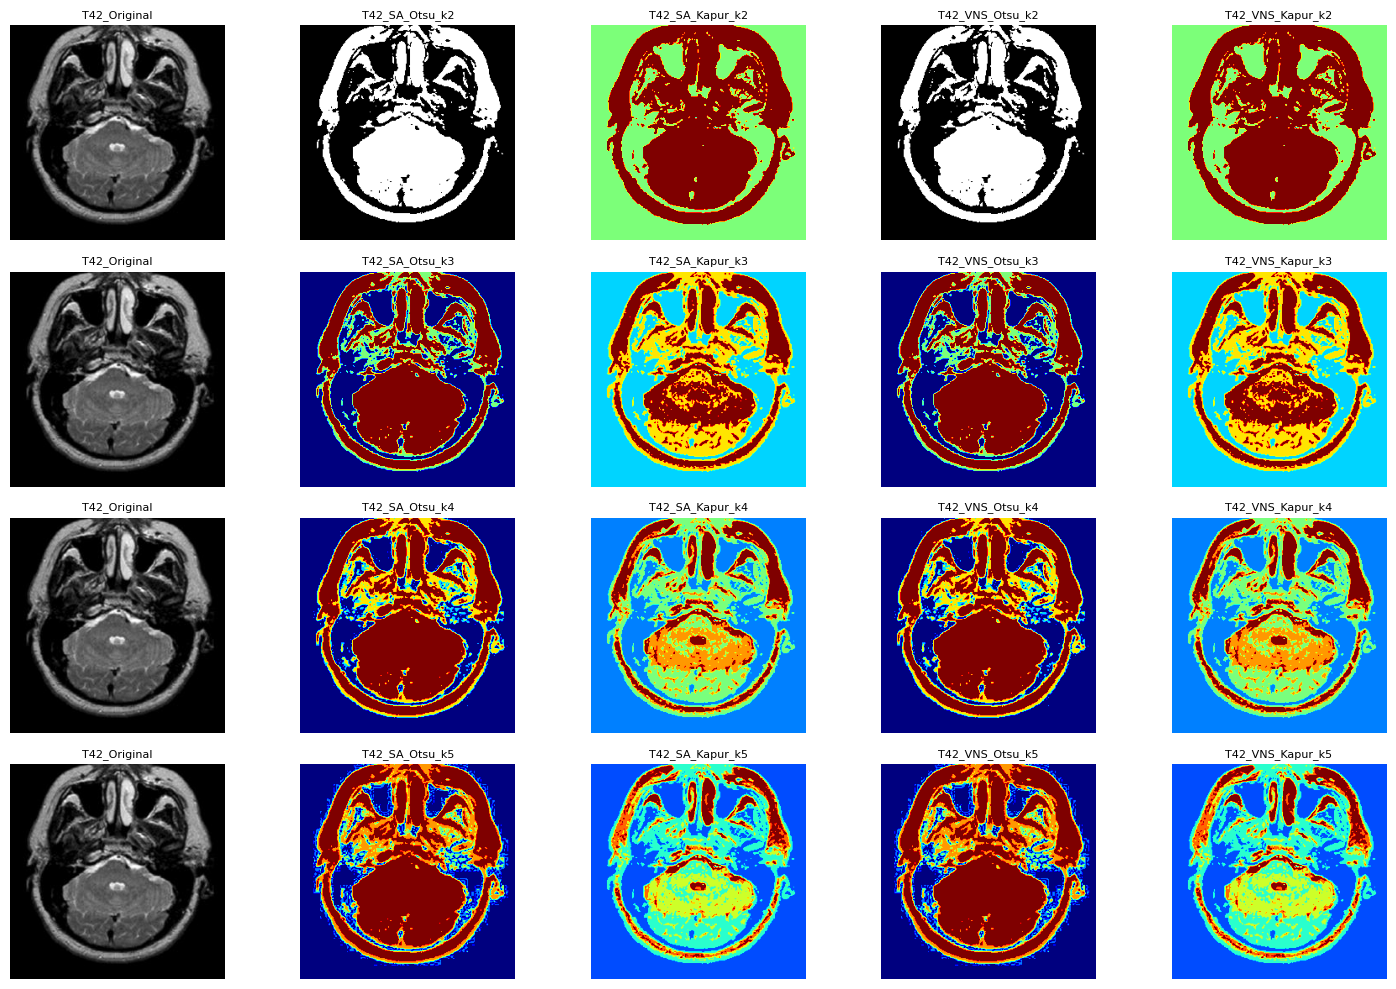

In [115]:
import matplotlib.pyplot as plt

# Function to plot the histogram of the image
def plot_histogram(image, title):
    plt.figure(figsize=(6, 4))
    plt.hist(image.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
    plt.title(f'Gray Level Histogram of {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Image', 'Level', 'Method', 'Optimization', 'Thresholds', 'Objective Value', 'SSIM', 'PSNR'])

# Main execution block for image processing with results logging
for filename, image in images:
    name_without_extension = os.path.splitext(filename)[0]
    print(f"Processing image: {filename}")
    
    processed_images = []  # List to store processed images across multiple k
    image_titles = []      # List to store titles of images
    thresholds_list = []  

    # Loop through different k levels (e.g., k=2, k=3, etc.)
    for k in [2, 3, 4, 5]:
        print(f"Processing k={k}")
        
        # Append the original image before each row of processed images
        original_image = image.copy()  # Copy of the original image
        processed_images.append(original_image)
        image_titles.append(f'{name_without_extension}_Original')
        thresholds_list.append(None)  # No thresholds for original images

        # Simulated Annealing + Otsu
        sa_otsu_thresholds = simulated_annealing(image, otsu_objective, k)
        segmented_sa_otsu, _ = otsu_multilevel_thresholding(image, len(sa_otsu_thresholds) + 1)
        ssim_sa_otsu = ssim(image, segmented_sa_otsu)
        psnr_sa_otsu = psnr(image, segmented_sa_otsu)
        otsu_obj_value = otsu_objective(image, sa_otsu_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_SA_Otsu_k{k}: {np.unique(segmented_sa_otsu)}")
        results_df = log_results(results_df, name_without_extension, k, "Otsu", "Simulated Annealing", sa_otsu_thresholds, otsu_obj_value, ssim_sa_otsu, psnr_sa_otsu, np.unique(segmented_sa_otsu).tolist())
        processed_images.append(segmented_sa_otsu)
        image_titles.append(f'{name_without_extension}_SA_Otsu_k{k}')
        thresholds_list.append(sa_otsu_thresholds)
        
        # Simulated Annealing + Kapur
        sa_kapur_thresholds = simulated_annealing(image, kapur_objective, k)
        segmented_sa_kapur, _ = kapur_threshold(image, len(sa_kapur_thresholds) + 1)
        ssim_sa_kapur = ssim(image, segmented_sa_kapur)
        psnr_sa_kapur = psnr(image, segmented_sa_kapur)
        kapur_obj_value = kapur_objective(image, sa_kapur_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_SA_Kapur_k{k}: {np.unique(segmented_sa_kapur)}")
        results_df = log_results(results_df, name_without_extension, k, "Kapur", "Simulated Annealing", sa_kapur_thresholds, kapur_obj_value, ssim_sa_kapur, psnr_sa_kapur, np.unique(segmented_sa_kapur).tolist())
        processed_images.append(segmented_sa_kapur)
        image_titles.append(f'{name_without_extension}_SA_Kapur_k{k}')
        thresholds_list.append(sa_kapur_thresholds)

        # Variable Neighbourhood Search + Otsu
        vns_otsu_thresholds = vns(image, otsu_objective, k)
        segmented_vns_otsu, _ = otsu_multilevel_thresholding(image, len(vns_otsu_thresholds) + 1)
        ssim_vns_otsu = ssim(image, segmented_vns_otsu)
        psnr_vns_otsu = psnr(image, segmented_vns_otsu)
        otsu_obj_value_vns = otsu_objective(image, vns_otsu_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_VNS_Otsu_k{k}: {np.unique(segmented_vns_otsu)}")
        results_df = log_results(results_df, name_without_extension, k, "Otsu", "Variable Neighborhood Search", vns_otsu_thresholds, otsu_obj_value_vns, ssim_vns_otsu, psnr_vns_otsu, np.unique(segmented_vns_otsu).tolist())
        processed_images.append(segmented_vns_otsu)
        image_titles.append(f'{name_without_extension}_VNS_Otsu_k{k}')
        thresholds_list.append(vns_otsu_thresholds)
        
        # Variable Neighbourhood Search + Kapur
        vns_kapur_thresholds = vns(image, kapur_objective, k)
        segmented_vns_kapur, _ = kapur_threshold(image, len(vns_kapur_thresholds) + 1)
        ssim_vns_kapur = ssim(image, segmented_vns_kapur)
        psnr_vns_kapur = psnr(image, segmented_vns_kapur)
        kapur_obj_value_vns = kapur_objective(image, vns_kapur_thresholds)  # Calculate objective value
        print(f"Unique values for {name_without_extension}_VNS_Kapur_k{k}: {np.unique(segmented_vns_kapur)}")
        results_df = log_results(results_df, name_without_extension, k, "Kapur", "Variable Neighborhood Search", vns_kapur_thresholds, kapur_obj_value_vns, ssim_vns_kapur, psnr_vns_kapur, np.unique(segmented_vns_kapur).tolist())
        processed_images.append(segmented_vns_kapur)
        image_titles.append(f'{name_without_extension}_VNS_Kapur_k{k}')
        thresholds_list.append(vns_kapur_thresholds)

    # Display images with the original image at the beginning of every row
    display_images(processed_images, image_titles, cols=5, figsize=(15, 10))  # Display 5 images per row
    display_histograms(processed_images, image_titles, thresholds_list=thresholds_list, cols=5, figsize=(15, 10))

# ! this is to save results to a csv file
# After the loop, output the results DataFrame
display(results_df)

# Save the logged results to a CSV file
results_df.to_csv('segmentation_results.csv', index=False)

print("Results have been logged and saved to 'segmentation_results.csv'.")                                                                                                                                        